<a href="https://colab.research.google.com/github/gr3ybr0w/Contraception_prediction/blob/master/contraception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Contraceptive

This data comes from http://archive.ics.uci.edu/ml/index.php and is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The overall goal of this notebook is to demostrate analysis and machine learning tools to predict the current contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from pandas.plotting import scatter_matrix, andrews_curves, autocorrelation_plot, bootstrap_plot, radviz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import scipy

from sklearn.externals.six import StringIO  
from IPython.display import Image  

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from sklearn import cluster
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder, MultiLabelBinarizer, Binarizer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Collecting the data

In [0]:
#Attribute Information:
#
#   1. Wife's age                     (numerical)
#   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
#   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
#   4. Number of children ever born   (numerical)
#   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
#   6. Wife's now working?            (binary)           0=Yes, 1=No
#   7. Husband's occupation           (categorical)      1, 2, 3, 4
#   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
#   9. Media exposure                 (binary)           0=Good, 1=Not good
#   10. Contraceptive method used     (class attribute)  1=No-use 
#                                                        2=Long-term
#                                                        3=Short-term

In [0]:
# Using pandas to download and load the data into a data frame.
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data', names=['Wife_age', 'Wife_education', 'Husband_education', 'Number_of_children_ever_born', 'Wife_religion', 'Wife_now_working', 'Husband_occupation', 'Standard_of_living_index',
              'Media_exposure', 'Contraceptive_method_used'])

In [0]:
# changing the column names to those that are easier to use
df.columns = ['Wife_age', 'Wife_education', 'Husband_education', 'Number_of_children_ever_born', 'Wife_religion', 'Wife_now_working', 'Husband_occupation', 'Standard_of_living_index',
              'Media_exposure', 'Contraceptive_method_used']

df.drop([0], inplace=True)

In [0]:
# manually setting the data types for each column
df['Wife_age'] = df.Wife_age.astype(np.int32)
df['Number_of_children_ever_born'] = df.Number_of_children_ever_born.astype(np.int32)
df['Wife_education'] = df.Wife_education.astype(str)
df['Husband_education'] = df.Husband_education.astype(str)
df['Husband_occupation'] = df.Husband_occupation.astype(str)
df['Standard_of_living_index'] = df.Standard_of_living_index.astype(str)
df['Wife_religion'] = df.Wife_religion.astype(str)
df['Wife_now_working'] = df.Wife_now_working.astype(str)
df['Media_exposure'] = df.Media_exposure.astype(str)
df['Contraceptive_method_used'] = df.Contraceptive_method_used.astype(str)

# Explore the data

<h2>Data Overview</h2>

In [21]:
df.head()

,Wife_age,Wife_education,Husband_education,Number_of_children_ever_born,Wife_religion,Wife_now_working,Husband_occupation,Standard_of_living_index,Media_exposure,Contraceptive_method_used
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
5,19,4,4,0,1,1,3,3,0,1


In [22]:
pd.concat([df.describe(include='all'), pd.DataFrame(df.isna().sum(), columns=['number_of_missing']).T, pd.DataFrame(df.dtypes, columns=['dtypes']).T])

,Wife_age,Wife_education,Husband_education,Number_of_children_ever_born,Wife_religion,Wife_now_working,Husband_occupation,Standard_of_living_index,Media_exposure,Contraceptive_method_used
count,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472
unique,NaN,4,4,NaN,2,2,4,4,2,3
top,NaN,4,4,NaN,1,1,3,4,0,1
freq,NaN,577,899,NaN,1252,1103,585,684,1363,628
mean,32.5442,NaN,NaN,3.26155,NaN,NaN,NaN,NaN,NaN,NaN
std,8.22703,NaN,NaN,2.35934,NaN,NaN,NaN,NaN,NaN,NaN
min,16,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
25%,26,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
50%,32,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
75%,39,NaN,NaN,4.25,NaN,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


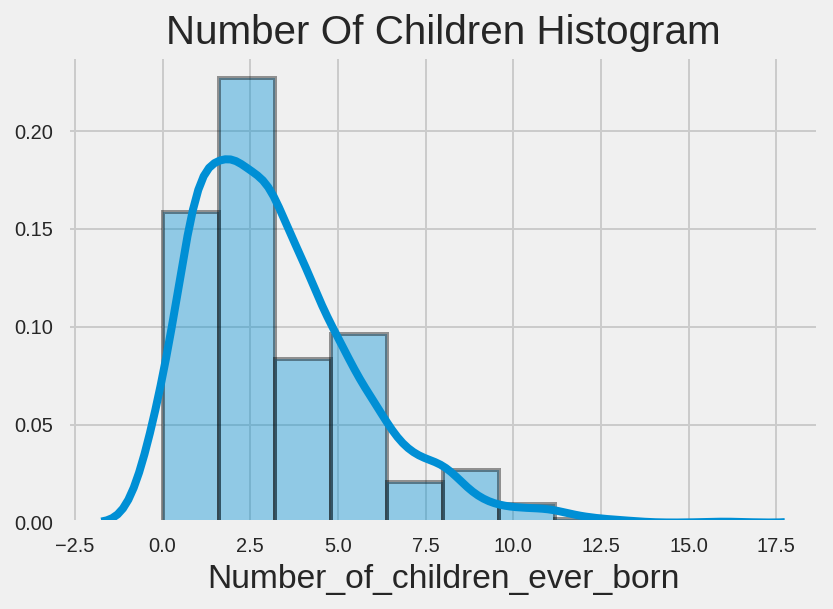

In [38]:
sns.distplot(df.Number_of_children_ever_born, bins=10, hist_kws=dict(edgecolor="k", linewidth=2)).set_title('Number Of Children Histogram');

Number_of_children_ever_born: Averages at 3.26 but has a max value of 16, this could be considered a outlier though might also have strong correlationDictionary with age.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


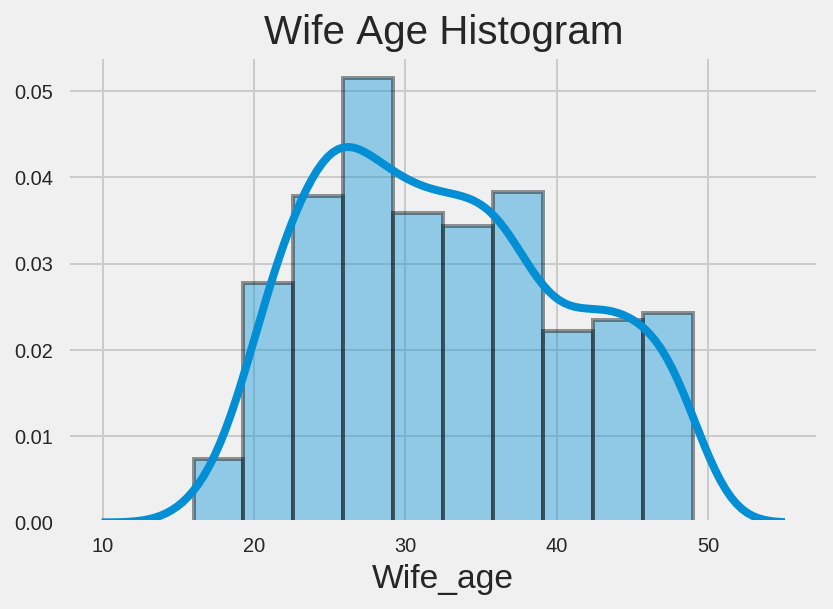

In [39]:
sns.distplot(df.Wife_age, bins=10, hist_kws=dict(edgecolor="k", linewidth=2)).set_title('Wife Age Histogram');

Wife_age: The mean age of a wife is quite low and only reaching an max age of 49. This could mean a number of different things. Firstly the population this is sampled from has a low life expectancy. Secondly that the sample is not a true spread representation of the great population in that it has been filtered by a know criteria ie Only those over 16 and under 50. Thirdly an unknown filter ie some women over 50 are not able to anwser the survey. This means that any results drawn from this anaysis and modelling might only apply to a subset of the population and might not be generalizable.

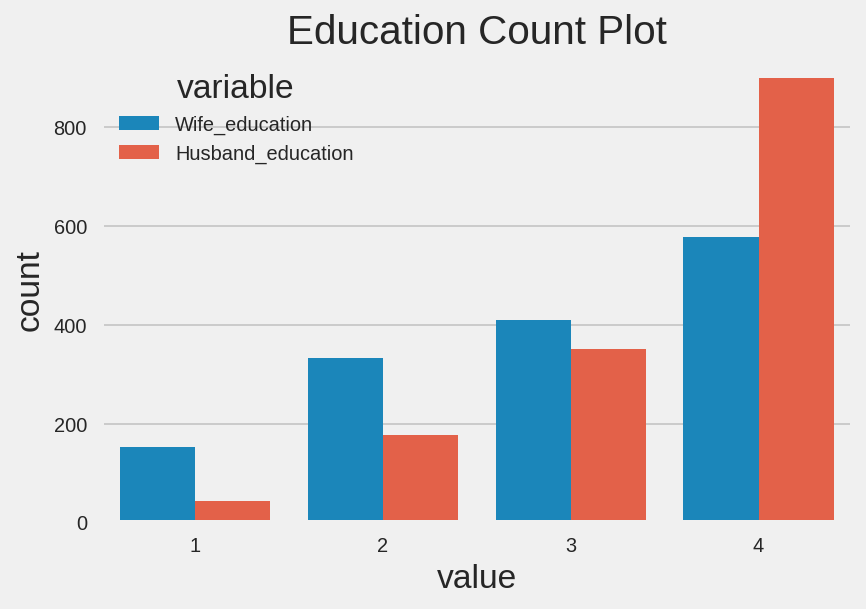

In [40]:
educationMelt = df.melt(value_vars=['Wife_education', 'Husband_education'])
sns.countplot(x='value', hue='variable', data=educationMelt).set_title('Education Count Plot');

Wife_education and Husband education: Out of the 4 catergories the one representing 'high' education is the most common for both wife and husbands. We can also see that the husbands are more likely to have a 'high' education.

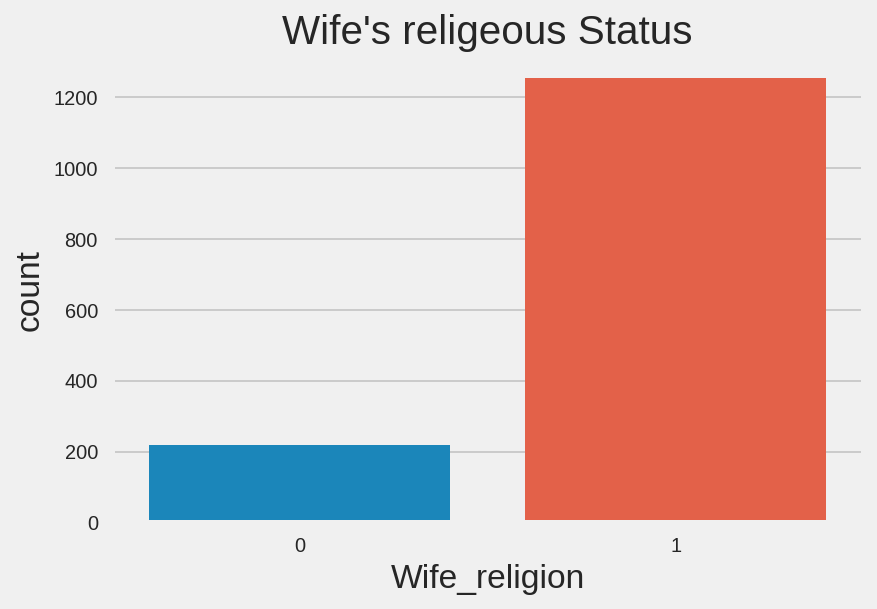

In [41]:
sns.countplot(x='Wife_religion', data=df).set_title("Wife's religeous Status");

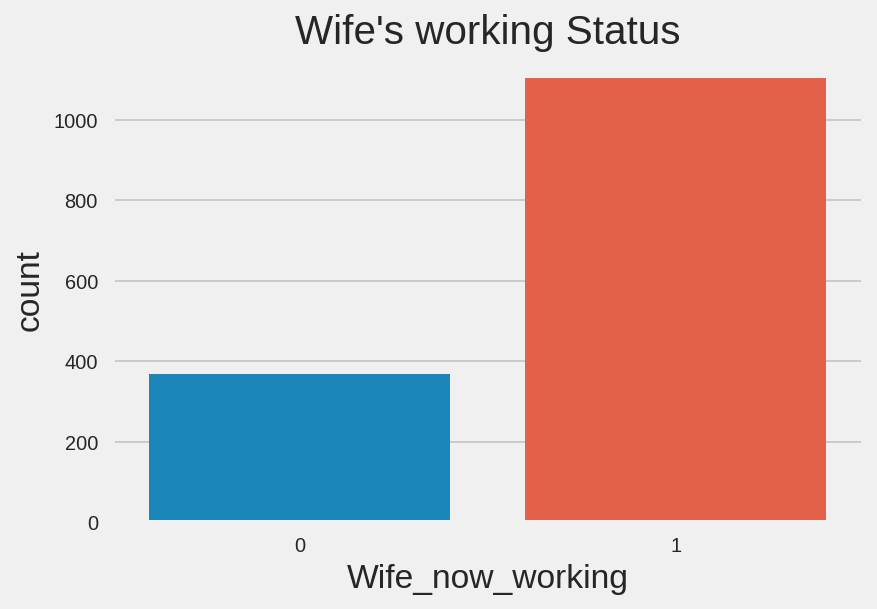

In [42]:
sns.countplot(x='Wife_now_working', data=df).set_title("Wife's working Status");

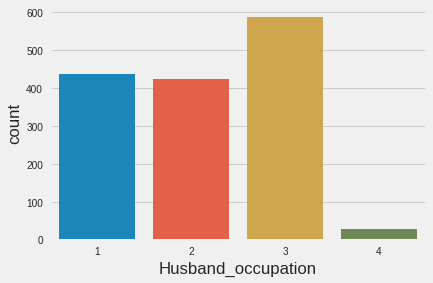

In [0]:
sns.countplot(x='Husband_occupation', data=df);

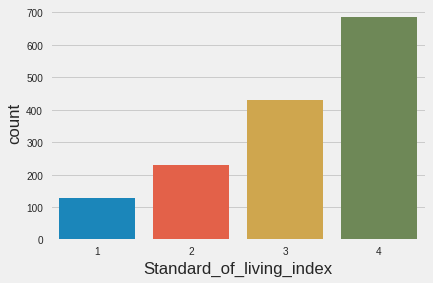

In [0]:
sns.countplot(x='Standard_of_living_index', data=df);

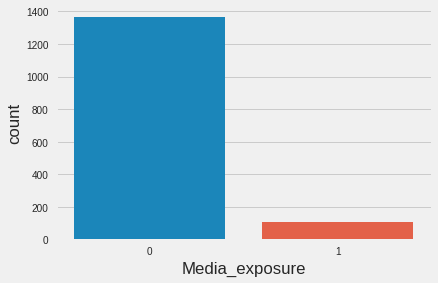

In [0]:
sns.countplot(x='Media_exposure', data=df);

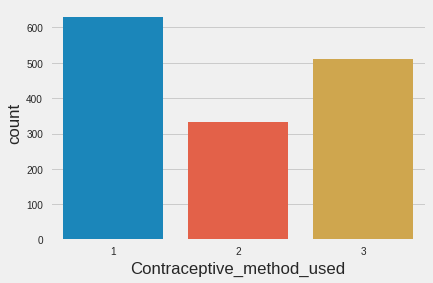

In [0]:
sns.countplot(x='Contraceptive_method_used', data=df);

In [0]:
df.corr().style.background_gradient()

,Wife_age,Number_of_children_ever_born
Wife_age,1,0.540248
Number_of_children_ever_born,0.540248,1


Categorical Vs Continuous

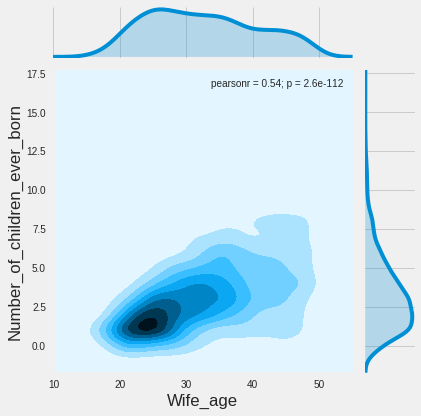

In [0]:
sns.jointplot('Wife_age', 'Number_of_children_ever_born', data=df, kind='kde');

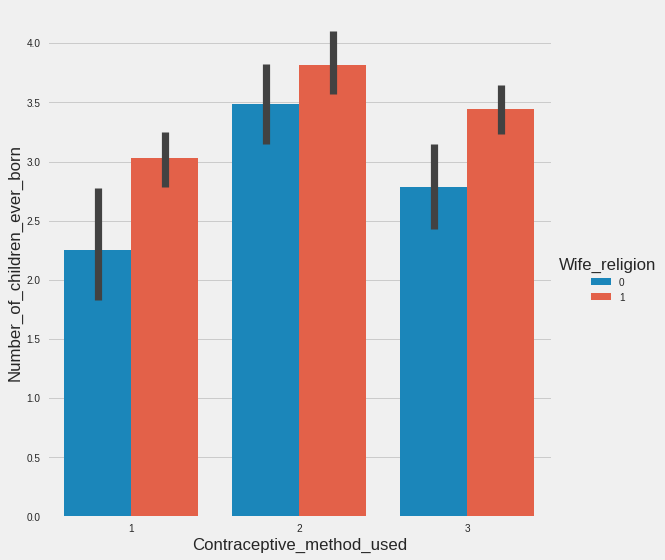

In [0]:
sns.factorplot(x='Contraceptive_method_used', y='Number_of_children_ever_born', hue='Wife_religion', data=df, kind='bar', size=8);

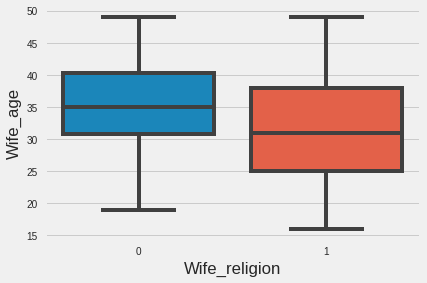

In [0]:
sns.boxplot(x='Wife_religion', y='Wife_age', data=df);

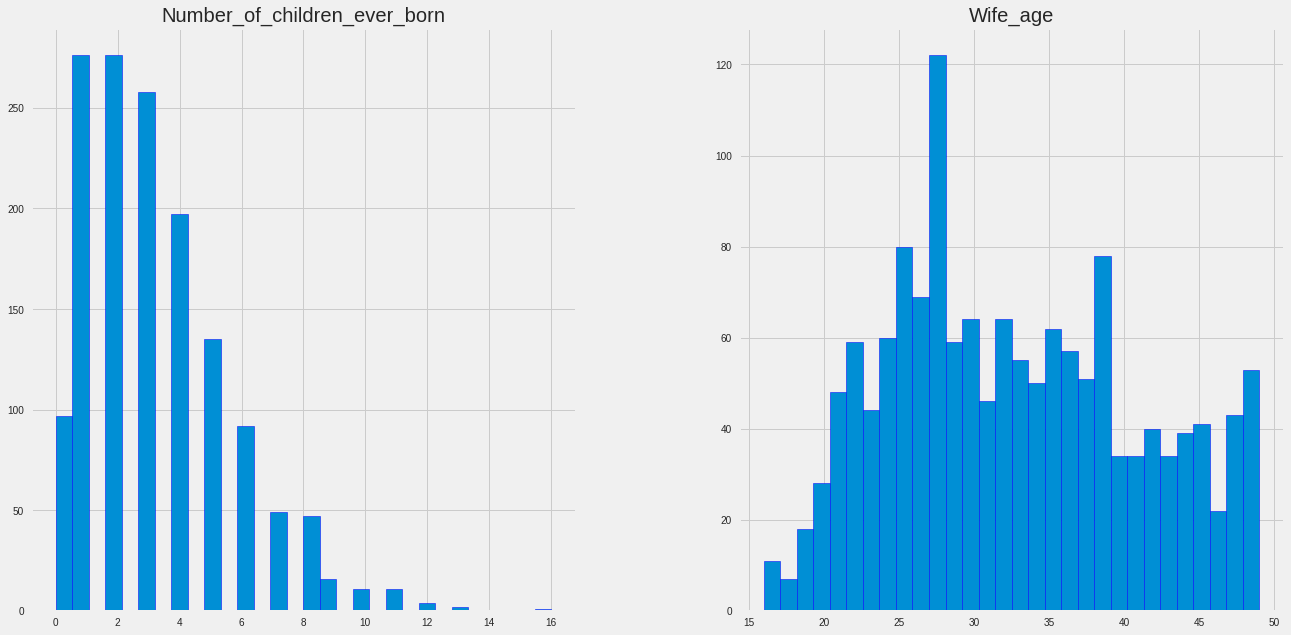

In [0]:
df.hist(bins=30, figsize=(20,10), edgecolor='b');

# split the data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Number_of_children_ever_born', axis=1), df['Number_of_children_ever_born'], test_size=0.2)

In [0]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    def get_feature_names(self):
        return df.columns.tolist()

In [0]:
# the labelbinarizer is made for labels and will not natively work in the pipeline. This hacks that.
class SupervisionFriendlyLabelBinarizer(LabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(SupervisionFriendlyLabelBinarizer, self).fit_transform(X)
    def get_feature_names(self):
        return df.columns.tolist()

In [0]:
colnames = list(df)

In [0]:
df.dtypes

Wife_age                         int32
Wife_education                  object
Husband_education               object
Number_of_children_ever_born     int32
Wife_religion                   object
Wife_now_working                object
Husband_occupation              object
Standard_of_living_index        object
Media_exposure                  object
Contraceptive_method_used       object
dtype: object

In [0]:
num_attribs = ['WIFE_AGE', 'NO_CHILDREN']
cat_attribs = ['WIFE_EDUCATION', 'HUSBAND_EDUCATION', 'RELIGION', 'WORKING', 'HUSBAND_OCCUPATION', 'STANDARD_OF_LIVING', 'MEDIA_EXPOSURE']

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        #('LabelBinarizer', SupervisionFriendlyLabelBinarizer()),
        ('onehot', OneHotEncoder())
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [0]:
num_attribs = ['WIFE_AGE', 'NO_CHILDREN']
cat_attribs = ['WIFE_EDUCATION', 'HUSBAND_EDUCATION', 'RELIGION', 'WORKING', 'HUSBAND_OCCUPATION', 'STANDARD_OF_LIVING', 'MEDIA_EXPOSURE']

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline2 = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        #('LabelBinarizer', SupervisionFriendlyLabelBinarizer()),
        #('onehot', OneHotEncoder())
    ])

full_pipeline2 = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline2),
    ])

In [0]:
cmc_prepared = full_pipeline.fit_transform(strat_train_set_X)
cmc_prepared

<1178x24 sparse matrix of type '<class 'numpy.float64'>'
	with 10602 stored elements in Compressed Sparse Row format>

In [0]:
cmc_prepared2 = full_pipeline2.fit_transform(strat_train_set_X)
cmc_prepared2

array([[1.8854959991276858, -0.10824913401359731, '4', ..., '2', '4', '0'],
       [1.1565049307050348, 1.1543001716103407, '4', ..., '1', '3', '0'],
       [0.06301832807105824, -0.10824913401359731, '2', ..., '2', '4', '0'],
       ..., 
       [-0.42297571754404245, -0.10824913401359731, '2', ..., '3', '3', '0'],
       [1.7639974877239106, -0.52909890255491, '1', ..., '1', '3', '0'],
       [-0.3014772061402673, 0.3126006345277153, '2', ..., '2', '4', '0']], dtype=object)

In [0]:
full_pipeline2

FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['WIFE_AGE', 'NO_CHILDREN'])), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('cat_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['WIFE_EDUCATION', 'HUSBAND_EDUCATION', 'RELIGION', 'WORKING', 'HUSBAND_OCCUPATION', 'STANDARD_OF_LIVING', 'MEDIA_EXPOSURE']))]))],
       transformer_weights=None)

In [0]:
strat_train_set_y = strat_train_set_y.CONTRACEPTIVE_USED.map({'No_use': 0, 'Shot_term': 1, 'Long_term': 2})

In [0]:
strat_train_set_y.values

array([0, 2, 1, ..., 1, 0, 1])

In [0]:
sgbC = SGDClassifier(max_iter=1000)
sgbC.fit(cmc_prepared, strat_train_set_y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [0]:
y_train_pred = cross_val_predict(sgbC, cmc_prepared, strat_train_set_y, cv=3)
y_train_pred

array([0, 1, 0, ..., 0, 0, 0])

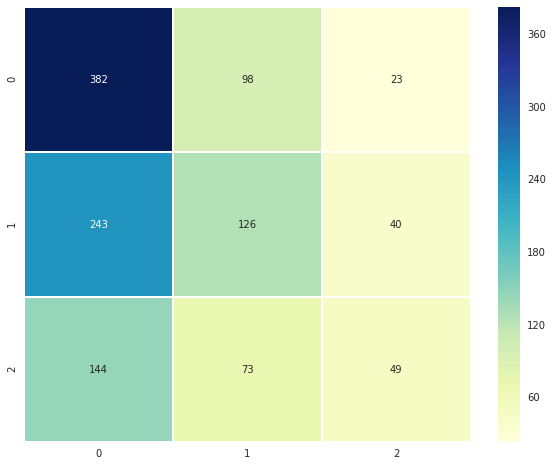

In [0]:
cmx = confusion_matrix(strat_train_set_y, y_train_pred)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cmx, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="YlGnBu");

In [0]:
mplC = MLPClassifier()
mplC.fit(cmc_prepared, strat_train_set_y)

/home/thomas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [0]:
y_train_pred = cross_val_predict(mplC, cmc_prepared, strat_train_set_y, cv=3)
y_train_pred

/home/thomas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thomas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thomas/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([0, 2, 1, ..., 1, 0, 2])

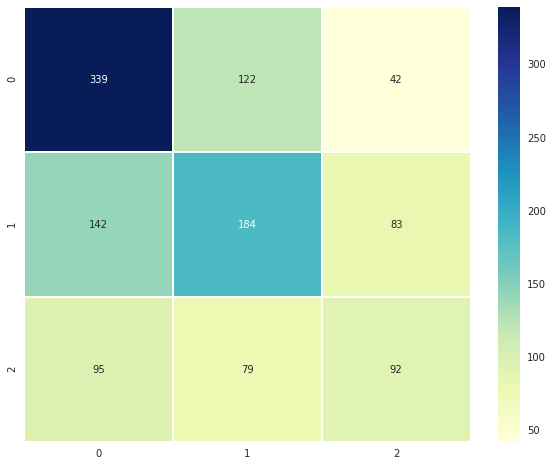

In [0]:
cmx = confusion_matrix(strat_train_set_y, y_train_pred)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cmx, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="YlGnBu");

In [0]:
knC = KNeighborsClassifier(n_neighbors=3)
knC.fit(cmc_prepared, strat_train_set_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [0]:
y_train_pred = cross_val_predict(knC, cmc_prepared, strat_train_set_y, cv=3)
y_train_pred

array([0, 2, 1, ..., 0, 0, 0])

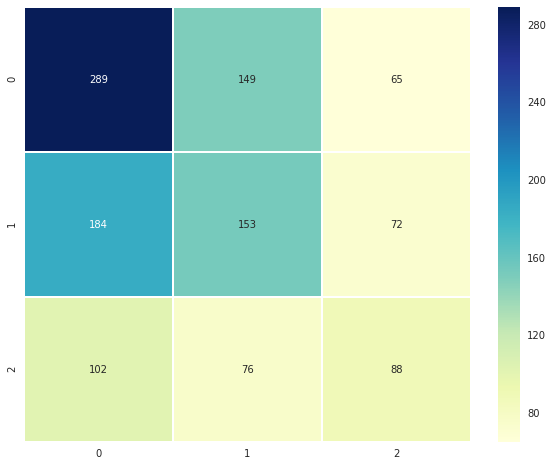

In [0]:
cmx = confusion_matrix(strat_train_set_y, y_train_pred)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cmx, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="YlGnBu");

In [0]:
svc = SVC()
svc.fit(cmc_prepared, strat_train_set_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
y_train_pred = cross_val_predict(svc, cmc_prepared, strat_train_set_y, cv=3)
y_train_pred

array([0, 2, 0, ..., 1, 0, 1])

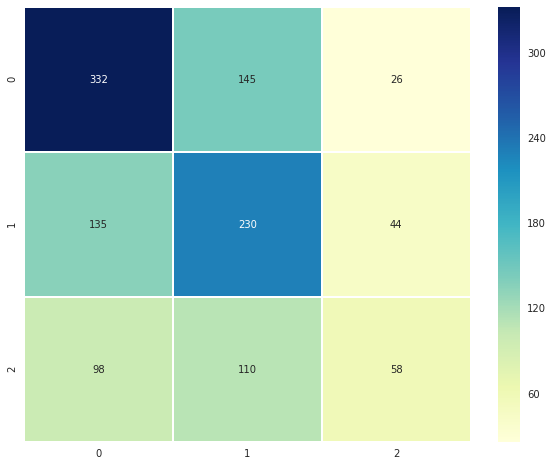

In [0]:
cmx = confusion_matrix(strat_train_set_y, y_train_pred)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cmx, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="YlGnBu");

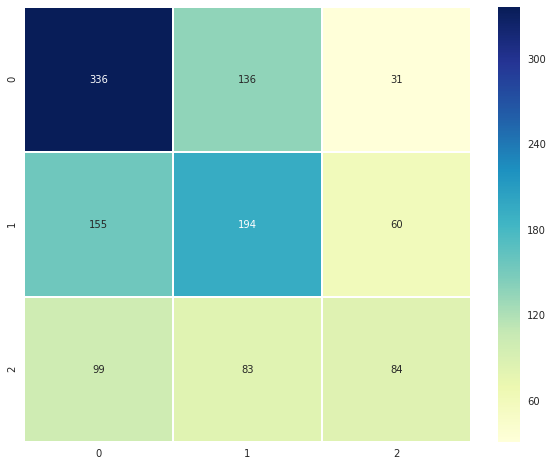

In [0]:
gpc = GaussianProcessClassifier()
svc.fit(cmc_prepared, strat_train_set_y)
y_train_pred = cross_val_predict(gpc, cmc_prepared.toarray(), strat_train_set_y, cv=3)

cmx = confusion_matrix(strat_train_set_y, y_train_pred)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cmx, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="YlGnBu");

In [0]:
cmc_prepared2.shape

(1178, 9)

In [0]:
colnames

['WIFE_AGE',
 'WIFE_EDUCATION',
 'HUSBAND_EDUCATION',
 'NO_CHILDREN',
 'RELIGION',
 'WORKING',
 'HUSBAND_OCCUPATION',
 'STANDARD_OF_LIVING',
 'MEDIA_EXPOSURE',
 'CONTRACEPTIVE_USED']

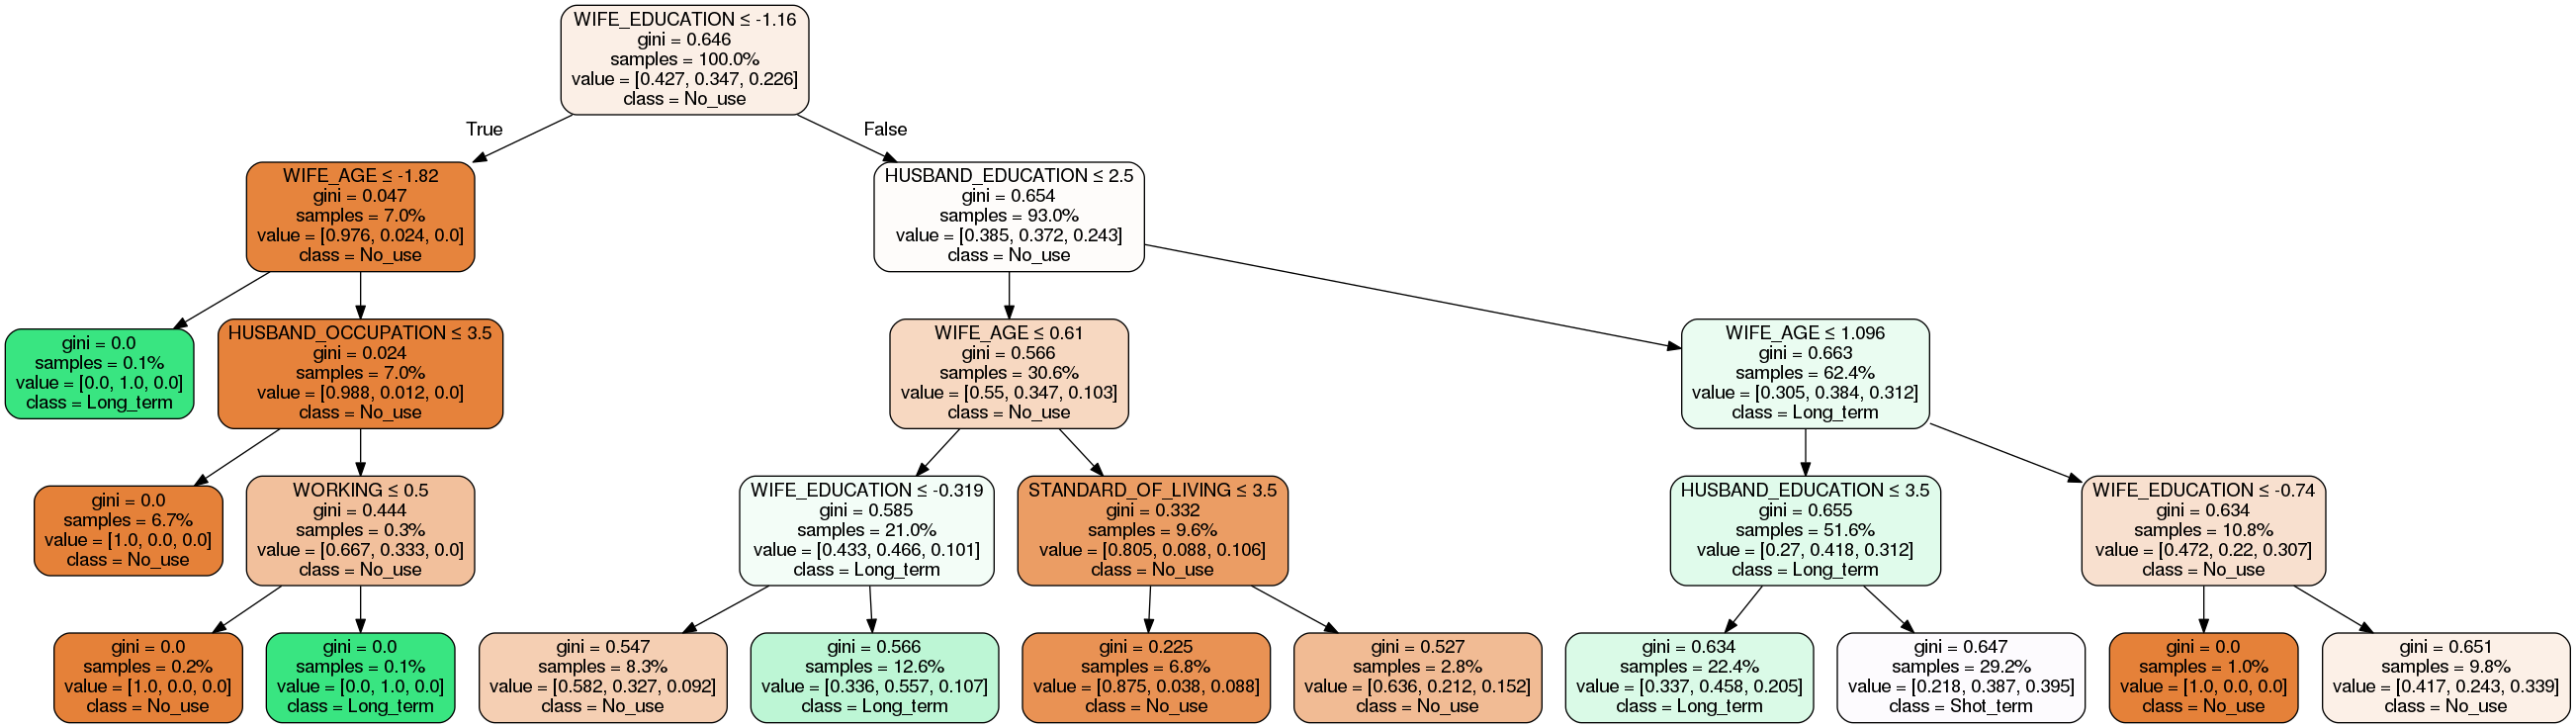

In [0]:
dtc = DecisionTreeClassifier(max_depth=4)
dt_model = dtc.fit(cmc_prepared2, strat_train_set_y)
dot_data = StringIO()
export_graphviz(dt_model, feature_names=colnames[:-1], class_names=['No_use','Long_term','Shot_term'], out_file=dot_data, proportion=True,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [0]:
graph.write_png('./asdf.png')

True

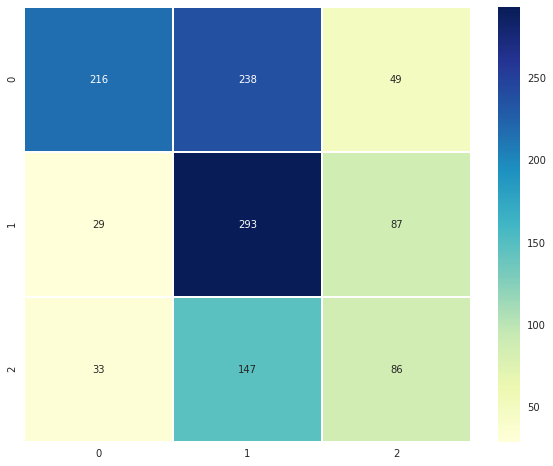

In [0]:
y_train_pred = cross_val_predict(dtc, cmc_prepared, strat_train_set_y, cv=3)

cmx = confusion_matrix(strat_train_set_y, y_train_pred)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cmx, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="YlGnBu");

In [0]:
rfc = RandomForestClassifier()
svc.fit(cmc_prepared, strat_train_set_y)
y_train_pred = cross_val_predict(rfc, cmc_prepared, strat_train_set_y, cv=3)

cmx = confusion_matrix(strat_train_set_y, y_train_pred)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cmx, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="YlGnBu")

In [0]:
abc = AdaBoostClassifier()
svc.fit(cmc_prepared, strat_train_set_y)
y_train_pred = cross_val_predict(abc, cmc_prepared, strat_train_set_y, cv=3)

cmx = confusion_matrix(strat_train_set_y, y_train_pred)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cmx, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="YlGnBu");